# ABC's of Natural Language Processing Machine Learning <br>
## Beginners Guide  - Teacher Funding Applications Playground - [DonorChoose.org](https://www.donorschoose.org/)
_By Nick Brooks, March 2018_

## Table of Content:
1. **Feature Engineering:**
    - Extracting information from Resource Dataset
    - Hand made features and Sentiment Analysis
    - The curious incident of the *"Date Cutoff"*
    - Time Variables, Gender Variable, Multi-Application Teachers
    - Label Encoding, and Dummy Variables
    - Multiple TF-IDF: Full Guide
2. **Modeling:**
    - Train/Validation and DMatrix
    - Introduction to Extreme Boosting and its paradigm family
    - Hyperparameter Guide
    - Model
    - Feature Importance
    - Tree Graphic

***

## Resource Dataset and Hand Made Text Feature Engineering

**Includes:** <br>
- Vader Sentiment Analysis
- Eight Hand Made Features

**Applied to:** <br>
- **"text" ** : All essays joined together
- **"project_resource_summary"**: Variable from main dataset
- **"project_title"**: Variable from main dataset
- **"description"**: All descriptions from resource dataset joined together. Also summed the quantity, price, and counted the number of resources requested by teacher.
***
*Load and Combine Test and Train for Combined Processing:* <Br>

In [2]:
import time
start = time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix
from sklearn.pipeline import FeatureUnion

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer

# models
from sklearn import feature_selection
#import xgboost as xgb
#import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn import preprocessing
from scipy.sparse import hstack, csr_matrix
import scipy.stats as st

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import gc

# Load
train = pd.read_csv("train.csv",index_col="id",low_memory=False,
                    parse_dates=["project_submitted_datetime"])#.sample(1000,random_state=23)
traindex = train.index
test = pd.read_csv("test.csv",index_col="id",low_memory=False,
                    parse_dates=["project_submitted_datetime"])#.sample(1000,random_state=23)
tesdex = test.index
y = train["project_is_approved"].copy()
df = pd.concat([train.drop("project_is_approved",axis=1),test],axis=0)
alldex = df.index

# Resource DF
rc = pd.read_csv("resources.csv",index_col="id").fillna("missing")

/anaconda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


*Imbalanced Depedent Variable - Brief Visualizations*

- This is always a key aspect to review when conducting Machine Learning.
- My model must take this into account, or else it will struggle to generalize.

Approved: 84.7682337434095%
Denied: 15.23176625659051%


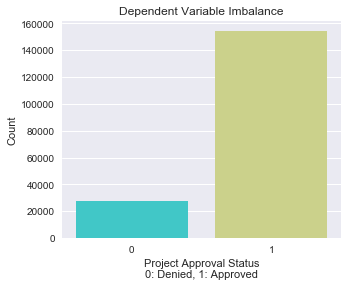

In [3]:
# Percentages
print("Approved: {}%\nDenied: {}%".format(*y.value_counts(normalize=True)*100))

# Plot
f, ax = plt.subplots(figsize=[5,4])
sns.countplot(y,ax=ax, palette="rainbow")
ax.set_title("Dependent Variable Imbalance")
ax.set_ylabel("Count")
ax.set_xlabel("Project Approval Status\n0: Denied, 1: Approved")
plt.show()

*Here, the resource dataset is delt with:*

- Here the `groupby` function uses the `.agg` extension to compute multiple different descriptive statistics for multiple different columns.
- Since this function outputs columns with multiple-index, I combine elements from both tiers and collapse them.
- Since some teachers only posted one requested resource entry in the resource df, those teachers have their *price_std* as NA. Delt with this problem with `.fillna()`

In [6]:
# Aggregate and Merge
agg_rc = rc.reset_index().groupby('id').agg(
    dict(quantity = ['sum',"mean"],
         price = ["sum","mean","max","min","std"],
         id = 'count',
         description = lambda x: ' nicapotato '.join(x))).rename(columns={"id" : "count"})

# Collapse Multi-index
agg_rc.columns = pd.Index([e[0] +"_"+ e[1] for e in agg_rc.columns.tolist()])
agg_rc.rename({'count_count':"count",'description_<lambda>': "description"},inplace=True)
agg_rc.price_std.fillna(0,inplace=True)

# Merge
df = pd.merge(df,agg_rc, left_index=True, right_index=True, how= "left")
del test, train, rc,agg_rc
gc.collect()

869

*Project Essays are joined together with a space in between*

- This step is in preperation of Term Frequency-Inverse Document Frequency **[TF-IDF]**
- Thanks to [Heads or Tails'](https://www.kaggle.com/c/donorschoose-application-screening/discussion/51352) sleuthing, I know that DonorChoose.org reduced the number of essays in its applications from four to two after May 17 2016. By combining all four, this alleviates some of the problem, but applications pre-cutoff may be skewed since they will have more words.
- Lastly, its best practise to review the distributions and trends in the data before attempting to build a model. Heads or Tails has a [comprehensive notebook](https://www.kaggle.com/headsortails/an-educated-guess-donorschoose-eda) available.

In [7]:
# Feature Engineering
df['text'] = df.apply(lambda row: ' '.join([
    str(row['project_essay_1']), 
    str(row['project_essay_2']), 
    str(row['project_essay_3']), 
    str(row['project_essay_4'])]), axis=1)

*Numerous hand made features with Sentiment Analysis:* <br>
- Compound, Neutral, Negative and Positive Sentiment is collected.
- **Neutral/Negative/Positive Score:** Indicates the potency of these classes between 0 and 1.
- **Polarity Score:** Measures the difference between the Positive/Neutral/Negative values, where a positive numbers closer to 1 indicates overwhelming positivity, and a negative number closer to -1 indicates overwhelming negativity.

In [8]:
%%time

# Text Features for feature extraction
text_cols = ["text","project_resource_summary", "project_title", "description"]

# Sentiment Build
print("Hand Made Text Features..")
SIA = SentimentIntensityAnalyzer()
for cols in text_cols:
    df[cols] = df[cols].astype(str) # Make Sure data is treated as string
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols+'_num_chars'] = df[cols].apply(len) # Count number of Characters
    df[cols+'_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols+'_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    # Count Unique Words
    df[cols+'_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words']*100
    # Unique words to Word count Ratio
    if cols == "text":
        df[cols+"_vader_Compound"]= df[cols].apply(lambda x:SIA.polarity_scores(x)['compound'])
    #     df[cols+'_vader_Neutral']= df[cols].apply(lambda x:SIA.polarity_scores(x)['neu'])
    #     df[cols+'_vader_Negative']= df[cols].apply(lambda x:SIA.polarity_scores(x)['neg'])
        df[cols+'_vader_Positive']= df[cols].apply(lambda x:SIA.polarity_scores(x)['pos'])
        # Test a Stemmer..
    print("{} Done".format(cols))

Hand Made Text Features..


KeyboardInterrupt: 

*Number of Words before and after May 17, 2016*

In [6]:
# Date Cutoff Variable
df["Date_Cutoff"] = None
df.loc[df["project_submitted_datetime"] > "05/16/2016","Date_Cutoff"] = "After"
df.loc[df["project_submitted_datetime"] <= "05/16/2016","Date_Cutoff"] = "Before"

# Plot
f, ax = plt.subplots(1,4, figsize=[14,4])
for i, plotcol in enumerate(["text_num_words","text_num_unique_words","text_words_vs_unique","text_vader_Compound"]):
    sns.boxplot(data=df, y=plotcol,x="Date_Cutoff",ax=ax[i], palette="rainbow")
    ax[i].set_xlabel("May 17th 2016 Cutoff")
    ax[i].set_ylabel("{}".format(plotcol.replace(r'_',' ').capitalize()))
    ax[i].set_title("{}\nby Date Cutoff".format(plotcol.replace(r'_',' ').capitalize()))
plt.tight_layout(pad=0)
plt.show()

There is a difference between groups.
***
*Time and Categories Features*
- For time, I choose to isolate:
    - Year,
    - Day of the Year
    - Weekday
    - Day of the Month
    - Quarter of the Year
- *Project Subject Categories and Subcategories* are tricky since various schooling departments, such as: Math, Literature, etc.. are combined and seperated by a comma. To tackle this, the string parser `sep=', '` is used within the `get_dummies` arguements, swiftly seperating and encoding the various subjects.
- Next I handle *Teacher_id*. Originally, I had encoded this with `LabelEncoder`, but after further examination, I noticed that most teachers sent one app total, with a minority of 58 submitting two. Encoding and even dummy variables don't capture this pattern because it is unable to generalize is into "teachers who have sent more than one application". Thats why I created a boolean variable to capture that - *'multi_apps'*.
- After, I create an clearer *Gender* variable, but decide to keep the original teacher prefix.

In [7]:
# Time Variables
df["Year"] = df["project_submitted_datetime"].dt.year
df["Date of Year"] = df['project_submitted_datetime'].dt.dayofyear # Day of Year
df["Weekday"] = df['project_submitted_datetime'].dt.weekday
df["Weekd of Year"] = df['project_submitted_datetime'].dt.week
df["Day of Month"] = df['project_submitted_datetime'].dt.day
df["Quarter"] = df['project_submitted_datetime'].dt.quarter

# Split the strings at the comma, and treat them as dummies
df = pd.merge(df, df["project_subject_categories"].str.get_dummies(sep=', '),
              left_index=True, right_index=True, how="left")
df = pd.merge(df, df["project_subject_subcategories"].str.get_dummies(sep=', '),
              left_index=True, right_index=True, how="left")
              
# Teacher ID
teachr_multi_subs = df['teacher_id'].value_counts().reset_index()
df["multi_apps"]= df['teacher_id'].isin(teachr_multi_subs.loc[teachr_multi_subs["teacher_id"]>1,'index'].tolist())
# Percentages
print("Teacher App Distribution:\nTwo Apps: {}%\nOne App: {}%\n".format(*df["multi_apps"].value_counts(normalize=True)*100))

# Teacher Gender
df["Gender"] = None
df.loc[df['teacher_prefix'] == "Mr.","Gender"] = "Male"
df.loc[df['teacher_prefix'] == "Teacher","Gender"] = "Not Specified"
df.loc[(df['teacher_prefix'] == "Mrs.")|(df['teacher_prefix'] == "Ms."),"Gender"] = "Female"

print("Gender Distribution:\nFemale: {}%\nMale: {}%\nNot Specified: {}%".format(*df["Gender"].value_counts(normalize=True)*100))

Women professors are overwhelmingly more likely to request funding!

In [8]:
# Heatmap to see Gender and Teaching Grade of Teachers
f, ax = plt.subplots(figsize=[6,4])
sns.heatmap(pd.crosstab(df.project_grade_category,df.Gender,normalize='columns').mul(100).round(0),
            annot=True, linewidths=.5,fmt='g', cmap="rainbow", vmin=0, vmax=100,ax=ax,
            cbar_kws={'label': '% Percentage'})
ax.set_title("Percentage by Row of Gender in Grade Range")
ax.set_xlabel("")
ax.set_ylabel("")
plt.show;

According to the [Association of American Educators](https://www.aaeteachers.org/index.php/blog/757-the-teacher-gender-gap) quote:
> "Male educators constitute just 2.3% of pre-K and kindergarten teachers, 18.3% of the elementary and middle school teacher population, and 42% of the high school level teaching staff.  These numbers are down from 2007, but suggest a clear female majority in the teaching profession, especially in the earlier grades. (source: [BLS](https://www.bls.gov/cps/cpsaat11.pdf))"

***
*`Dummy` and `LabelEncoding`:*
- Since *Project Grade Category* is ordinal in nature, as in the escalation from elementary to primary school signifies older students, it receives `LabelEncoder`. *Multi-apps* and *Date cutoff* are also of interest, so they were be transformed from True/False to Boolean (1,0).
- Lastly, I dummy encoded the time variables, aswell as *teacher_prefix*, *school_state*, *project_grade_category*. 

In [9]:
# Encoder:
encode = ["project_grade_category",'multi_apps', "Date_Cutoff", 'teacher_prefix',"teacher_id"]
lbl = preprocessing.LabelEncoder()
for col in encode:
     df[col] = lbl.fit_transform(df[col].astype(str))

# Dummies:
timevars = ['Weekday','Weekd of Year','Day of Month','Year','Date of Year',"Quarter"]
df = pd.get_dummies(df, columns=["Gender",'school_state','project_grade_category']+timevars)

In [10]:
# Text
text_cols = ["project_resource_summary", "project_title","description","text"]

df.drop(['project_subject_categories',"project_subject_subcategories","project_submitted_datetime",
         "project_essay_1","project_essay_2","project_essay_3","project_essay_4"
        ],axis=1,inplace=True)
normalize = ["teacher_number_of_previously_posted_projects","quantity","price"]
gc.collect()

***
## **[TF-IDF]** : *Term Frequency-Inverse Document Frequency*  <br>

This is a text processing stage in the *Bag of Words* family. 
- Text processing means turning chunks of text into something machine learning models can understand.. So some kind of numeric representation.
- Bag of Words signifies that it looks for word occurence in text chunk, and completely ignores the sequencial significance of language (to the extent that n-grams are used..)

**TF-IDF** calculates how important a word is in a document (in this case, a text feature such as *all the paragraphs*) in comparison to the entire corpus (so all the paragraphs by *ALL* the teachers)

Resources: <br>
- [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)
- [Bill Chamber's Blog Post](http://billchambers.me/tutorials/2014/12/21/tf-idf-explained-in-python.html)

My Parameters: <br>
- **sublinear:** Regularization technique, that squishes the data to a lower, common magnitude -> 1 + log(tf)
- **strip_accents:** Gets rid of any special characters from foreign languages. These essays are all in English so that shoudn't make a difference.
- **stop_words:** This cleans the text for common, low-impact, filler words such as the, a, an, in ..etc, to make way for words that distinguish.
- **analyzer:** Choice between *Word* and *Character*. Textual level of analysis. In our case, *Word* is ideal since its all the text is in English with formal and clean spelling. This is not always the case. For example for the [Toxic Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge), characters are also saught after. Heck, try it on this set of data, but beware the risk of overfitting.
- **token_pattern:** Regular Expression to define specification of words saught. Let's further explain`r'\w{1,}'`
    - `r""`: This  treats the piece as raw code, so that backslashes are treated as part of the regex, instead of attempting to format the string (Like \n would go to the line)
    - `\w`: Specifies only letters, numbers and _ spaces. Sorry aliens :(
- **ngram_range:** Specify the size of each word "token". If the range is (2,3), then two and three consecutive word groups will be selected to vectorize.
- **max_features:** Maximum number of features created. If `none`, then only top features are considered. Tune this threshold with *min_df and max_df*.
- **norm:** Its easy to assume that this is a form of normalization in the likes of Ridge or Lasso. However, that is incorrect.
    - `l2` infact refers to *Cosine Distance*, which normalizes our vectorizer to documents of variant length. Therefore, the fact that teachers only submitted two essasys after May 17th 2016 is delt with. 
    - [Now in our case, if the cosine similarity is 1, they are the same document. If it is 0, the documents share nothing.](http://billchambers.me/tutorials/2014/12/22/cosine-similarity-explained-in-python.html)
    - I am keeping the May 17th 2016 cutoff variable just incase to cross-reference the decision tree feature importance.

**min_df and max_df:** [Quoted Verbatum from Kevin Markham's StackOverflow post](https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer)<br>
max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:
- **max_df** = 0.50 means "ignore terms that appear in more than 50% of the documents".
- **max_d**f = 25 means "ignore terms that appear in more than 25 documents".
The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

min_df is used for removing terms that appear too infrequently. For example:
- **min_df** = 0.01 means "ignore terms that appear in less than 1% of the documents".
- **min_d*f** = 5 means "ignore terms that appear in less than 5 documents".
The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.

-**Smooth_Idf:** Whether to add a zero to the numerator and denominator of the TD-IDF. Prevents zero division, where some words in the training process get ignored.



*Here, TD-IDF is applied to: **Text, Project Resource Summary, Project Title and Description** Seperately*
- I decided to take this approach in order to not miss out on the specific purpose that these text chunks serve. For example, project_resource_summary tends to include the exact items seeking funding. Perhaps `Coutvectorizin` this could give the model more information about the types of items that receive the most funding.

In [11]:
# Lets look at these variables!
print("\nDtypes of DF features:\n",df.dtypes.value_counts())
print("\nDF Shape: {} Rows, {} Columns".format(*df.shape))

In [12]:
tfidf_para = {
    "sublinear_tf":True,
    "strip_accents":'unicode',
    "stop_words":"english",
    "analyzer":'word',
    "token_pattern":r'\w{1,}',
    #"ngram_range":(1,1),
    "dtype":np.float32,
    "norm":'l2',
    "min_df":5,
    "max_df":.8,
    "smooth_idf":False
}

*Reflection on my parameters:* <br>
Something I noticed about my model is its tendency to overfit massively, boasting a training AUC score in the ~0.9s, while maintaining a validation score in the high ~0.7s. To tackle this, I am trying to be harsher on my word vectors, increasing the minimum required occurence of words, as well as getting rid of more common words.

In [13]:
# Thanks To
# https://www.kaggle.com/lopuhin/eli5-for-mercari
# https://www.kaggle.com/jagangupta/understanding-approval-donorschoose-eda-fe-eli5/notebook

def get_col(col_name):
    return lambda x: x[col_name]

textcols = ["text","project_resource_summary","project_title","description"]
vectorizer = FeatureUnion([
        ('text',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=20000,
            **tfidf_para,
            preprocessor=get_col('text'))),
        ('project_resource_summary',TfidfVectorizer(
            ngram_range=(1, 1),
            **tfidf_para,
            max_features=2000,
            preprocessor=get_col('project_resource_summary'))),
        ('project_title',TfidfVectorizer(
            ngram_range=(1, 1),
            **tfidf_para,
            max_features=1500,
            preprocessor=get_col('project_title'))),
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            max_features=2000,
            preprocessor=get_col('description'))),
#         ('Non_text',DictVectorizer())
    ])

In [14]:
start_vect=time.time()
ready_df = vectorizer.fit_transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

*Lets look at the top features in the Training Set!*

In [15]:
# Sort and Print
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(ready_df.toarray()).flatten()[::-1]
print("Most Important Words in All Vectorization:\n",feature_array[tfidf_sorting][:20])

These steps are important because it enables a peak into the model's psychology. That is: what is it picking up on, and is that what we had in mind? Does it seem unconnected to receiving grants? Is it *ethical*?
***

In [16]:
df.drop(textcols,axis=1, inplace=True)
# Lets look at these variables!
print("\nDtypes of DF features:\n",df.dtypes.value_counts())
print("\nDF Shape: {} Rows, {} Columns".format(*df.shape))


***
## Modeling with eXtreme Gradient Boosting

**Make Dense dataframe Sparse, and Combine with TF-IDF features:** <br>
This step is to consolidate all the features created into one cohesive training and test set.

You have have noticed `gc.collect()` sprinkled here and there. It stands for *"Garbage Collector"*, and it releases unreferenced memory. So it is utilized when large/ data is deleted.

In [17]:
X = hstack([ready_df[0:traindex.shape[0]],csr_matrix(df.loc[traindex,:].values)])
testing = hstack([ready_df[traindex.shape[0]:],csr_matrix(df.loc[tesdex,:].values)])
tfvocab = tfvocab + df.columns.tolist()
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
del df
gc.collect();

*Train and Validation:* <br>
- Validation is extremely important to ensure the models generalizability for cases outside the training set! 
- `DMatrix` from the xgboost package is an extremely important step, enabling the model to handle much more data at a higher dimensionality more efficiently! [Big Shoutou to jmbull and his kernel](https://www.kaggle.com/jmbull/xtra-credit-xgb-w-tfidf-feature-stacking/notebook) which helped me out tremendously. 

In [18]:
# Training and Validation Set
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=23)

# XGBOOST Sparse Feature Storage
d_train = xgb.DMatrix(X_train, y_train,feature_names=tfvocab)
d_valid = xgb.DMatrix(X_valid, y_valid,feature_names=tfvocab)
d_test = xgb.DMatrix(testing,feature_names=tfvocab)

***
This part is heavily influenced from my **[Introduction to Classification with Titanic](https://www.kaggle.com/nicapotato/titanic-voting-pipeline-stack-and-guide)**, which takes a conceptual look at over 10 models, and explains how they fit within different paradigms. Check it out!
***
## Model Paradigm:
**Decision Trees:** <br>
I like to think of decision trees as optimizing a series of “If/Then” statements, eventually assigning the value at the tree’s terminal node. Starting from one point at the top, features can then pass the various trials until being assigned its class at the end “leaf” nodes of the tree (technically, it's more like its root tip since the end nodes are visually represented at the bottom of the graph). Trees used here are binary trees, so nodes can only split into two ways.

**Gradient Boosting:** <br>
As the name suggest, Gradient Boosting iteratively trains models sequentially to minimize its objective function. This is a Greedy Algorithm, which makes the most favorable split when it can. This means it's short sighted and will also stop when the loss doesn’t improve.

**XGBoost - eXtreme Gradient Boosting: ** <br>
As the name suggest, Gradient Boosting on steroids. Infact, multiple steroids:
- **Regularization**
- **Computation Speed** and **Parallel Processing**
- Handles **Missing Values**
- Improves on Gradient Boosting ***'Greedy'*** tendencies. It does this by considering reaching the max depth and retroactively pruning 
- **Interruptible** and **Resumable**, as well as **Hadoop** capabilities.

XGBoost is able to approximate the Loss function more efficiently, thereby leading to faster computation and parallel processing. Inside its objective function, it has also incorporated a regularization term, L1 and L2, to stay clear of unnecessary high dimensional spaces and complexity.

## Hyper-Parameters:
*Some of these parameter names are for the scikit learn xgboost wrapper* <br>

**General Decision Tree Hyper-Parameters:** <br>
- **max_features:** This is the random subset of features to be considered for splitting operation, the lower the better to reduce variance. For Classification model, ideal max_features = sqr(n_var).
- **max_depth:** Maximum depth of the tree. Alternate method of control model depth is max_leaf_nodes, which limits the number of terminal nodes, effectively limiting the depth of the tree.
- **n_estimators:** Number of trees built before average prediction is made.
- **min_samples_split:** Minimum number of samples required for a node to be split. Small minimum would potentially lead to a “Bushy Tree”, prone to overfitting. According to Analytic Vidhya, should be around 0.5~1% of the datasize.
- **min_samples_leaf:** Minimum number of samples required at the Terminal Node of the tree. In Sklearn, an alternative min_weight_fraction_leaf is available to use fraction of the data instead of a fixed integer.
- **random_state:** Ensuring consistent random generation, like seed(). Important to consider for comparing models of the same type to ensure a fair comparison. May cause overfitting if random generation is not representative.

**Gradient Boosting Specific Hyper-Parameters:** <br>
- **eta: ** How much parameters are updated after each iteration of gradient descent. Low mean smaller steps, most likely to reach the global minimum, although there are cases where this doesn’t always work as intended.
- **n_estimators:** Note this is still the number of trees being built, but it within the GBC’s sequential methodology.
- **subsample:** Similar to the Bootstrap Aggregate method, controlling percentage of data utilized for a tree, although the standard is to sample *without* replacement. In this model, operates in similar ways to Stochastic Gradient Descent in Neural Networks, but with large batch sizes. <br>
*Note this decision trees are still a *Shallow Model*, so it is still profoundly different from Neural Networks.*
- **loss:** Objective Function minimized by gradient descent.
- **init:** Initialization of the model internal parameters. May be used to build off another model's’ outcome.

**Hyper-Parameters for Tree Classification Booster (Sklearn Wrapper):** <br>
- **Min_child_weight:** Similar strand to *min_child_leaf*, which controls the minimum number of observation to split to a terminal node. This instead relates to defines the minimum sum of derivatives found in the Hessian (second-order)of all observations required in a child.
- **Gamma:** Node is split only if it gives a positive decrease in the loss function. Higher performance regulator of complexity.
- **Max_delta_step:** What the tree’s weights can be.
- **Colsample_bylevel:** Random Forest characteristic, where it enables subfraction of features to be randomly selected for each tree.

**Regularization:** <br>
In the context of GBMs, regularization through shrinkage is available, but applying it to the model with the tree base-learner is different from its traditional coefficient constriction. For GBM Trees, the shrinking decreases the influence of each additional tree in the iterative process, effectively applying a decay of impact over boosting rounds. As a result, it no longer searches as the feature selection method, since it cannot adjust the coefficients of each feature (and potential interaction/ polynomial terms).

**Learning Task Parameters:**
- **Objective:** *binary:logistic* = Outputs probability for two classes.
- **Multi:** *softmax* = outputs prediction for *num_class* classes.
- **Multi:** *prob* = probability for 3 or more classes.

The objective is merely a matter of catering to the data type, although additional protocols on the probabilities may be set up. For example, the highest probability below a certain threshold may be deemed an inadequate score, passed over for human processing. The optimal loss function should cater to the behavior of the data and goal at hand, and usually requires input from the domain knowledge base.

The Evaluation Metric (*eval_metric*) has important implications depending on the problem at hand. If the dataset is imbalanced and the minority class is of interest, it is better to use [AUC] Area Under the Curve than accuracy or rmse, since those metrics can get away with assigning the majority class to all, and still get away with high accuracy!

*More Info:* <br>
- [Complete Guide to Parameter Tuning in Gradient Boosting (GBM) in Python by Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/) 
- [Gradient boosting machines, a tutorial by Alexey Natekin1 and Alois Knoll](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3885826/)
- [Complete Guide to XGBOOST with Analytic Vidhya](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
- [Python Installation Instructions](https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_For_Anaconda_on_Windows?lang=en)

In [19]:
xgb_params = {'eta': 0.1, 
              'max_depth': 8, 
              'subsample': 0.8, 
              'colsample_bytree': 0.8,
              'min_child_weight' : 1.5,
              'scale_pos_weight': (y.value_counts()[0]/y.value_counts()[1]),
              'objective': 'binary:logistic', 
              'eval_metric': 'auc', 
              'seed': 23,
              'lambda': 1.5,
              'alpha': .6
             }

In [20]:
modelstart = time.time()
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
model = xgb.train(xgb_params, d_train, 500, watchlist, verbose_eval=50, early_stopping_rounds=50)
xgb_pred = model.predict(d_test)

xgb_sub = pd.DataFrame(xgb_pred,columns=["project_is_approved"],index=tesdex)
xgb_sub.to_csv("xgb_sub.csv",index=True)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

*Reflection on Parameters:* <br>
Coming up once optimal parameters found.

*Model Interpretation:* <br>
Disclaimer: <br>
I stiched together the feature names from the various pre-processing steps, and I am concerned that this may not have translated correctly. I hope see if this checks out with other decision trees.

*Introducing the Feature Importance Bar Plot:* <br>
Since each split in the decision tree distinguishes the dependent variable, splits closer to the root, aka starting point, have optimally been determined to have the greatest splitting effect. The feature importance graphic measures how much splitting impact each feature has. It is important to note that this by no means points to causality, but just like in hierarchical clustering, does point to a nebulous groups. Furthermore, for ensemble tree methods, feature impact is aggregated over all the trees.

In [41]:
f, ax = plt.subplots(figsize=[7,10])
xgb.plot_importance(model,max_num_features=50,ax=ax)
plt.title("XGBOOST Feature Importance")
plt.show()

## LightGBM

Here I want to test [Oleg's Model Parameters](https://www.kaggle.com/opanichev/lightgbm-and-tf-idf-starter/code) on my data processing.

In [22]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 12,
    'num_leaves': 31,
    'learning_rate': 0.1, # Increased Learning Rate for now..
    'feature_fraction': 0.85,
    'bagging_fraction': 0.85,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 1,
    'lambda_l2': 1,
    'min_gain_to_split': 0,
}  

modelstart = time.time()
lgb_clf = lgb.train(
    lgbm_params,
    lgb.Dataset(X_train, y_train, feature_name=tfvocab),
    num_boost_round=400,
    valid_sets=[lgb.Dataset(X_valid, y_valid)],
    early_stopping_rounds=50,
    verbose_eval=50,
)

In [24]:
lgbmpred = lgb_clf.predict(testing)
lgbm_sub = pd.DataFrame(lgbmpred,columns=["project_is_approved"],index=tesdex)
lgbm_sub.to_csv("lgbm_sub.csv",index=True)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

In [40]:
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.show()


***
*Simple Blend:*

In [32]:
print("Model Correlation: ", pd.Series(lgbmpred).corr(pd.Series(xgb_pred)))

In [33]:
blend = (lgbmpred*.5) + (xgb_pred*.5)
blend_sub = pd.DataFrame(blend,columns=["project_is_approved"],index=tesdex)
blend_sub.to_csv("boost_blend_sub.csv",index=True)

In [39]:
concat_subs = pd.concat([lgbm_sub,xgb_sub,blend_sub], axis=1)
concat_subs.columns = ["LGBM","XGB","BLEND"]
concat_subs.corr()

In [35]:
print("Notebook Runtime: %0.2f Minutes"%((time.time() - start)/60))